In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
pd.set_option('display.max.columns', None)
df = pd.concat([df_train, df_test])
df.head(5)

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [3]:
#df["zip_code"] = df["zip_code"].astype(object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2521 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2521 non-null   int64  
 1   baths           2521 non-null   float64
 2   size            2521 non-null   float64
 3   size_units      2521 non-null   object 
 4   lot_size        2097 non-null   float64
 5   lot_size_units  2097 non-null   object 
 6   zip_code        2521 non-null   int64  
 7   price           2521 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 177.3+ KB


In [5]:
df["size"].sort_values()

770       250.0
809       376.0
1402      376.0
1520      376.0
477       376.0
         ...   
1616     6240.0
1554     6990.0
1862     7636.0
74       8660.0
232     11010.0
Name: size, Length: 2521, dtype: float64

<AxesSubplot:>

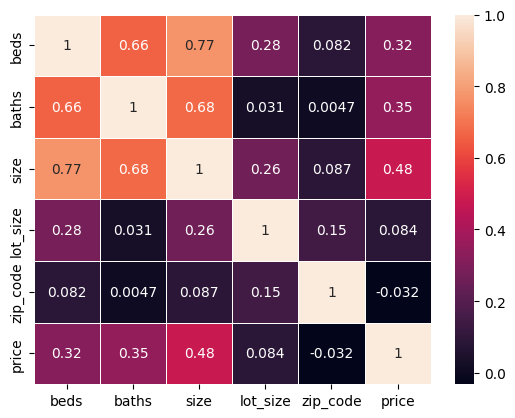

In [6]:
cor = df.corr()
sns.heatmap(cor, annot = True, linewidths=0.5)

In [7]:
X = df[["beds", "baths", "size"]]
y = df["price"]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
num_selector = make_column_selector(dtype_include=["int64", "float64"])
cat_selector = make_column_selector(dtype_exclude=["int64", "float64"])

num_processor = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("standard", StandardScaler())
])
cat_processor = OneHotEncoder(handle_unknown='ignore')

In [10]:
preprocessor = make_column_transformer(
    (num_processor, num_selector), (cat_processor, cat_selector)
)
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('standard',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17a51faf0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17a51fac0>)])

 #### Test Models

In [26]:
my_model = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
scores = []
names = []
for i in my_model:
    names.append(i)
    model5 = make_pipeline(preprocessor, i)
    model5.fit(X_train, y_train)
    scores.append(model5.score(X_test, y_test))

for n, s in zip(names, scores):
    print(f'Le model {n} à un score de {s}')

Le model LinearRegression() à un score de 0.6597112192825334
Le model Lasso() à un score de 0.6597114471365974
Le model Ridge() à un score de 0.6597058126679589
Le model ElasticNet() à un score de 0.5568336890837937


#### RandomizedSearchCV

In [32]:
model = make_pipeline(preprocessor, Lasso())

In [33]:
parameters = {"columntransformer__pipeline__imputer__strategy" : ["median", "mean", "most_frequent", "constant"],
              "lasso__alpha" : np.arange(0,20,0.1)} 

In [34]:
grid_pipeline = GridSearchCV(model,parameters, cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
print(grid_pipeline.best_params_)
print(grid_pipeline.best_score_)
print(grid_pipeline.best_estimator_)

{'columntransformer__pipeline__imputer__strategy': 'median', 'lasso__alpha': 19.900000000000002}
0.49298083777071894
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x288a689d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x288a68ca0>)])),
          